<a href="https://colab.research.google.com/github/chiaranovelli/DII4ET_exercise_naples/blob/main/ROM_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reduced-Order Modeling: Hydrogen flashback tutorial

## Introduction

This notebook uses a dataset obtained from **numerical simulations of a hydrogen flame**.  
The data are stored in a **2D snapshot matrix** `X` with dimensions `(n_space, n_time)`, where

- `n_space = n_features × nx × ny`  
- `nx = 601`, `ny = 201`   
  - x ∈ [0, 0.06] m  
  - y ∈ [-0.01, 0.01] m  
- `n_features = 5`
  1. Density (ρ)  
  2. Mass fraction of H₂  
  3. Mass fraction of H₂O  
  4. Mass fraction of OH  
  5. Temperature (T)
- `n_time = 1000`

This dataset represents the **temporal evolution of key thermochemical quantities** in a premixed flame, and will be used for:  

- loading and inspecting simulation data  
- performing **Proper Orthogonal Decomposition (POD)**  
- applying **linear and non-linear regression model** on the reduced space.

# 1. Data Loading

First we load the dataset from Drive.



In [1]:
!pip install -q gdown

In [ ]:
import numpy as np
drive_url = "https://drive.google.com/file/d/1vU195sdL4P9pzjUqVMr5FmhVqlTuWX5Y/view?usp=sharing"
out_name = "X_1500_2499.npy"

# Scarica da Drive
!gdown --fuzzy "$drive_url" -O "$out_name"

# Carica il dataset
X = np.load(out_name, mmap_mode=None)
print("Loaded:", out_name, "shape:", X.shape, "dtype:", X.dtype)

Downloading...
From (original): https://drive.google.com/uc?id=1vU195sdL4P9pzjUqVMr5FmhVqlTuWX5Y
From (redirected): https://drive.google.com/uc?id=1vU195sdL4P9pzjUqVMr5FmhVqlTuWX5Y&confirm=t&uuid=ed1c46b1-e731-40c4-a775-fd24aee48473
To: /content/X_1500_2499.npy
100% 2.42G/2.42G [00:51<00:00, 46.9MB/s]
✅ Caricato: X_1500_2499.npy shape: (604005, 1000) dtype: float32


To examine the structure of the dataset, we first create a plot.

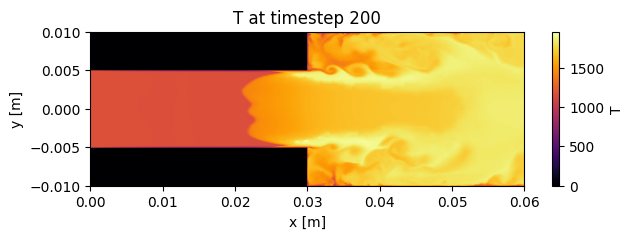

In [46]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

nx = 601
ny = 201
x_coords = np.linspace(0, 0.06, nx)
y_coords = np.linspace(-0.01, 0.01, ny)

features = ["DENSITY","H2","H2O","OH","T"]
symbols_l = [r'$\rho$', r'$Y_{\mathrm{H}_2}$', r'$Y_{\mathrm{H}_2\mathrm{O}}$', r'$Y_{\mathrm{OH}}$', r'T (K)']

n_space, n_time = X.shape

def plot_features(X, t , feature):
    feat_idx = features.index(feature)
    field = X[feat_idx*ny*nx:(feat_idx+1)*ny*nx, t].reshape((ny, nx))
    plt.figure(figsize=(7,2))
    plt.imshow(field, origin="lower", aspect="auto",
               extent=[x_coords[0], x_coords[-1], y_coords[0], y_coords[-1]],cmap='inferno')
    plt.colorbar(label=feature)
    plt.xlabel("x [m]"); plt.ylabel("y [m]")
    plt.title(f"{feature} at timestep {t}")
    plt.show()

plot_features(X, 200, 'T')

To gain a better understanding of the flashback phenomenon, we will create an animation:

In [48]:
import matplotlib.animation as animation
from IPython.display import HTML

def animate_feature(X, feature, t_start=0, t_end=None, step=10, cmap="inferno",
                    dynamic_clim=False, p_low=1, p_high=99):
    """Animate one feature over time with proper color scaling.
       dynamic_clim=False -> global robust colorbar (default)
       dynamic_clim=True  -> colorbar adapts each frame
    """
    if feature not in features:
        raise ValueError(f"{feature} not in {features}")
    fidx = features.index(feature)
    start = fidx * ny * nx
    end   = (fidx + 1) * ny * nx

    n_time = X.shape[1]
    if t_end is None: t_end = n_time
    frame_list = list(range(t_start, min(t_end, n_time), step))

    fig, ax = plt.subplots(figsize=(7, 2))
    x_mg, y_mg = np.meshgrid(x_coords, y_coords)

    vmin = vmax = None
    if not dynamic_clim:
        stride = max(1, len(frame_list)//20)
        sample_idx = frame_list[::stride] or frame_list
        data_block = X[start:end][:, sample_idx]
        finite = np.isfinite(data_block)
        if finite.any():
            vmin = np.percentile(data_block[finite], p_low)
            vmax = np.percentile(data_block[finite], p_high)
        else:
            vmin, vmax = 0.0, 1.0
        del data_block

    field0 = X[start:end, frame_list[0]].reshape((ny, nx))
    im = ax.imshow(field0, origin="lower", aspect="auto",
                   extent=[x_coords[0], x_coords[-1], y_coords[0], y_coords[-1]],
                   cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(im, ax=ax, label=feature)
    ax.set_xlabel("x [m]"); ax.set_ylabel("y [m]")

    def update(t):
        field = X[start:end, t].reshape((ny, nx))
        im.set_data(field)
        ax.set_title(f"{feature} at timestep {t}")
        if dynamic_clim:
            finite = np.isfinite(field)
            if finite.any():
                vmin_t = np.percentile(field[finite], p_low)
                vmax_t = np.percentile(field[finite], p_high)
                im.set_clim(vmin_t, vmax_t)
                cbar.update_normal(im)
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=frame_list, interval=100, blit=False)
    plt.close(fig)
    return ani


HTML(animate_feature(X, 'T', t_start=0, t_end=999, step=10).to_jshtml())